# Project Prompt

In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. Your submission must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that trains a model using the data set. In the notebook you should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README.
To enhance your submission, you might consider developing and comparing more than one model. Rest assured, all the above concepts will be explored in lecture videos and other materials in the coming semester.


# Approach

1. Plot the data to visually analyze it.

2. Based on the plot, we will see that there are a number of anomalies in the dataset. We will create models with and without these anomalies.

3. Create a model incorporating the anomalies and calculate the model's mean squared error. This will involved trial and error.

4. Create a model excluding the anomalies and calculate the model's mean squared error. This will involved trial and error.

5. Compare both models' mean squared error and decide which is more appropriate to use.

In [1]:
# Neural networks.
import tensorflow.keras as kr

# to split data into training and testing sets
from sklearn.model_selection import train_test_split

# for evaluating models
from sklearn import metrics

# Numerical arrays
import numpy as np

# Data frames.
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Plot style.
plt.style.use("ggplot")

# Make matplotlib show interactive plots in the notebook.
%matplotlib inline

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv')
# the first and last few rows have power values of zero, so we increase the number displayed
pd.set_option('display.min_rows', 30)
df

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


Text(0, 0.5, 'power')

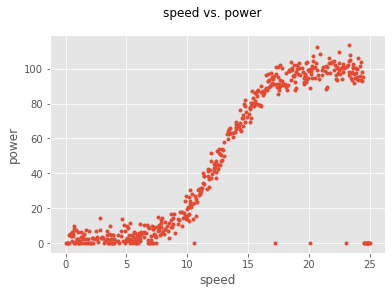

In [3]:
columns = df.columns
plt.plot(df[columns[0]], df[columns[1]], '.')
plt.suptitle(f'{columns[0]} vs. {columns[1]}')
plt.xlabel(f'{columns[0]}')
plt.ylabel(f'{columns[1]}')

We can immediately see that we are dealing with a [Sigmoid-like function](https://en.wikipedia.org/wiki/Sigmoid_function):



<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" width="400" height="500" align="left">

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

However, more relevant to our purpose is the even more basic fact that there is clearly a very strong relationship between speed and power, although it not linear but quadratic. The other important thing to notice is that there are a clear number of outliers in the sample where speed is relatively high but power is 0, and in particular, the last 10 points in the sample have power of zero, even though they have a very high speed value. Because these points clearly are not typical outliers in the sense that they all have the same y value and are so far from what we would expect them to be, there are really only three interpretations of their values:

1. They were incorrectly measured (perhaps the power values simply weren't recorded, and thus were entered as zero.

2. They values are accurate, and are explained by an external influence that over-rided the relationship between speed and power (e.g. perhaps their was no capacity on those days to store the electricity generated, so despite high speeds zero power was generated).

It is clear that there is not a continuous relationship between speed and power; rather there is a point of discontinuity past which speed increases but power is always equal to zero. If we look at the values in our sample, a speed value of 24.399 is the highest speed value for which power is not zero. Erring on the side of caution, we can take that point as the discontinuity point. Thus the mathematical definition of the relationship between speed (x) and power (y) will be as follows:

$x &gt; 0 \\y &gt; 0\\0 &lt; x &lt; 24.400, f(x) = y \\x &gt;= 24.400, f(x) = 0$

When creating a function to predict power based on speed, we will likely have to manually use flow control to determine whether to simply set the power to zero, or to actually apply or machine learning algorithm.

It is important also to consider here, however, the other points in our sample where speed is greater than 10 and yet power is zero. There is a legitimate question as to whether we should include or exclude those points. While it is possible that they were incorrectly measured (or power simply was not measured for those points at all and zero was entered in the transcription phase), it is also possible that some external influence may have over-rided the relationship between speed and power and caused power to be zero. Because these points are randomly dispersed and are few in number, the more responsible approach would be to assume the latter is true, and to include them in our calculations. This way, our models will account for that that on some occasions despite relatively high speeds, power can remain at zero.

In the below cells, then, I will first show that the cost of our model (here the mean squared error) is dramatically decreased if we exclude the final ten data points, and that is a strong reason for preferring the model with those anomolous points excluded.


## Create the Models

In [4]:
# Create a neural network with one neuron.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation="sigmoid", kernel_initializer='ones', bias_initializer='zeros'))
model.add(kr.layers.Dense(1, input_shape=(1,), activation="linear", kernel_initializer='ones', bias_initializer='zeros'))
model.compile(kr.optimizers.Adam(lr=0.0095), loss='mean_squared_error')

In [5]:
# split the dataset into training and testing data
# see here: https://realpython.com/train-test-split-python-data/
x_train, x_test, y_train, y_test = train_test_split(df[columns[0]][:490], df[columns[1]][:490], test_size=0.3)

In [6]:
# Train the neural network on our training data.
model.fit(x_train, y_train, epochs=350)

Epoch 1/350
11/11 [==============================] - 0s 3ms/step - loss: 1591.2704
Epoch 2/350
11/11 [==============================] - 0s 3ms/step - loss: 1564.2622
Epoch 3/350
11/11 [==============================] - 0s 3ms/step - loss: 1529.6036
Epoch 4/350
11/11 [==============================] - 0s 3ms/step - loss: 1474.4984
Epoch 5/350
11/11 [==============================] - 0s 3ms/step - loss: 1379.4651
Epoch 6/350
11/11 [==============================] - 0s 3ms/step - loss: 1193.1416
Epoch 7/350
11/11 [==============================] - 0s 3ms/step - loss: 999.4286
Epoch 8/350
11/11 [==============================] - 0s 3ms/step - loss: 879.9310
Epoch 9/350
11/11 [==============================] - 0s 2ms/step - loss: 804.5949
Epoch 10/350
11/11 [==============================] - 0s 2ms/step - loss: 725.0132
Epoch 11/350
11/11 [==============================] - 0s 2ms/step - loss: 661.1163
Epoch 12/350
11/11 [==============================] - 0s 2ms/step - loss: 602.1663
Epoch 1

11/11 [==============================] - 0s 1ms/step - loss: 86.1776
Epoch 101/350
11/11 [==============================] - 0s 2ms/step - loss: 86.1700
Epoch 102/350
11/11 [==============================] - 0s 2ms/step - loss: 86.4919
Epoch 103/350
11/11 [==============================] - 0s 1ms/step - loss: 86.9768
Epoch 104/350
11/11 [==============================] - 0s 2ms/step - loss: 85.9316
Epoch 105/350
11/11 [==============================] - 0s 1ms/step - loss: 88.1346
Epoch 106/350
11/11 [==============================] - 0s 1ms/step - loss: 85.2041
Epoch 107/350
11/11 [==============================] - 0s 1ms/step - loss: 85.1227
Epoch 108/350
11/11 [==============================] - 0s 1ms/step - loss: 86.7643
Epoch 109/350
11/11 [==============================] - 0s 1ms/step - loss: 85.3267
Epoch 110/350
11/11 [==============================] - 0s 1ms/step - loss: 83.9620
Epoch 111/350
11/11 [==============================] - 0s 1ms/step - loss: 84.8512
Epoch 112/350
11/1

11/11 [==============================] - 0s 1ms/step - loss: 77.3869
Epoch 199/350
11/11 [==============================] - 0s 1ms/step - loss: 77.5858
Epoch 200/350
11/11 [==============================] - 0s 1ms/step - loss: 77.0549
Epoch 201/350
11/11 [==============================] - 0s 1ms/step - loss: 76.7715
Epoch 202/350
11/11 [==============================] - 0s 2ms/step - loss: 77.5310
Epoch 203/350
11/11 [==============================] - 0s 1ms/step - loss: 76.3986
Epoch 204/350
11/11 [==============================] - 0s 1ms/step - loss: 76.5383
Epoch 205/350
11/11 [==============================] - 0s 1ms/step - loss: 76.5638
Epoch 206/350
11/11 [==============================] - 0s 1ms/step - loss: 76.6811
Epoch 207/350
11/11 [==============================] - 0s 1ms/step - loss: 76.0810
Epoch 208/350
11/11 [==============================] - 0s 1ms/step - loss: 77.4578
Epoch 209/350
11/11 [==============================] - 0s 1ms/step - loss: 77.7097
Epoch 210/350
11/1

11/11 [==============================] - 0s 1ms/step - loss: 72.2055
Epoch 297/350
11/11 [==============================] - 0s 1ms/step - loss: 72.9642
Epoch 298/350
11/11 [==============================] - 0s 1ms/step - loss: 72.7986
Epoch 299/350
11/11 [==============================] - 0s 1ms/step - loss: 74.2259
Epoch 300/350
11/11 [==============================] - 0s 1ms/step - loss: 73.1093
Epoch 301/350
11/11 [==============================] - 0s 1ms/step - loss: 72.3729
Epoch 302/350
11/11 [==============================] - 0s 1ms/step - loss: 72.9604
Epoch 303/350
11/11 [==============================] - 0s 1ms/step - loss: 72.9482
Epoch 304/350
11/11 [==============================] - 0s 1ms/step - loss: 73.0833
Epoch 305/350
11/11 [==============================] - 0s 1ms/step - loss: 73.0996
Epoch 306/350
11/11 [==============================] - 0s 1ms/step - loss: 72.7548
Epoch 307/350
11/11 [==============================] - 0s 1ms/step - loss: 72.5495
Epoch 308/350
11/1

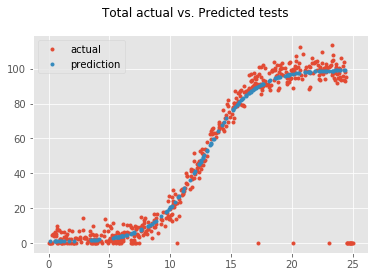

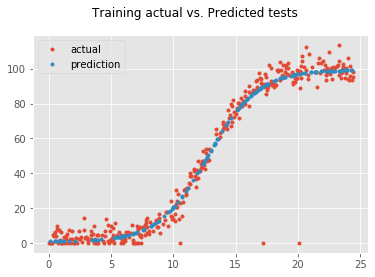

In [7]:
# Now let's see.
plt.plot(df[columns[0]], df[columns[1]], '.', label='actual')
plt.plot(x_test, model.predict(x_test), '.', label='prediction')
plt.suptitle("Total actual vs. Predicted tests")
plt.legend()
plt.show()

# Now let's see.
plt.plot(x_train, y_train, '.', label='actual')
plt.plot(x_test, model.predict(x_test), '.', label='prediction')
plt.suptitle("Training actual vs. Predicted tests")
plt.legend()
plt.show()

In [8]:
predictions = model.predict(x_test)

print("Mean squared error:")
print(metrics.mean_squared_error(y_test, predictions))

Mean squared error:
85.85264523673622


Our model has a mean square error of almost 100 when operating on our training set, it has a lower error value of around 20 on our testing set. This is a good indication that we haven't overfitted our model. What is interesting is for values of speed greater than around 16, our model appears to consistently underestimate power. This is possibly due to thethree data points that have speed values of greater than 16 but power values of zero. If we remove those values from the dataset, we will likely get a 'better fitting' model. We can try this now, although even if we arrive at a better model, the removal of those anomolous data points is still not likely justified, as they may indeed be legimitate values that will simply be intractable for a model that only looks as speed and power

In [9]:
newDF = df.loc[(df['speed']<16) | (df['power']!=0)]
newDF

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [10]:
# split the dataset into training and testing data
# see here: https://realpython.com/train-test-split-python-data/
x_train, x_test, y_train, y_test = train_test_split(newDF[columns[0]], newDF[columns[1]], test_size=0.3)

In [11]:
# Train the neural network on our training data.
model.fit(x_train, y_train, epochs=350)

Epoch 1/350
11/11 [==============================] - 0s 1ms/step - loss: 19.4423
Epoch 2/350
11/11 [==============================] - 0s 2ms/step - loss: 19.3572
Epoch 3/350
11/11 [==============================] - 0s 1ms/step - loss: 19.7586
Epoch 4/350
11/11 [==============================] - 0s 2ms/step - loss: 19.5724
Epoch 5/350
11/11 [==============================] - 0s 2ms/step - loss: 19.3428
Epoch 6/350
11/11 [==============================] - 0s 2ms/step - loss: 19.3448
Epoch 7/350
11/11 [==============================] - 0s 2ms/step - loss: 19.3482
Epoch 8/350
11/11 [==============================] - 0s 1ms/step - loss: 18.8078
Epoch 9/350
11/11 [==============================] - 0s 1ms/step - loss: 19.5133
Epoch 10/350
11/11 [==============================] - 0s 2ms/step - loss: 19.0370
Epoch 11/350
11/11 [==============================] - 0s 1ms/step - loss: 18.9543
Epoch 12/350
11/11 [==============================] - 0s 2ms/step - loss: 18.8247
Epoch 13/350
11/11 [=====

11/11 [==============================] - 0s 1ms/step - loss: 17.9314
Epoch 101/350
11/11 [==============================] - 0s 1ms/step - loss: 18.2403
Epoch 102/350
11/11 [==============================] - 0s 1ms/step - loss: 17.9428
Epoch 103/350
11/11 [==============================] - 0s 2ms/step - loss: 17.9456
Epoch 104/350
11/11 [==============================] - 0s 1ms/step - loss: 17.9833
Epoch 105/350
11/11 [==============================] - 0s 1ms/step - loss: 18.5443
Epoch 106/350
11/11 [==============================] - 0s 1ms/step - loss: 18.0801
Epoch 107/350
11/11 [==============================] - 0s 2ms/step - loss: 17.8201
Epoch 108/350
11/11 [==============================] - 0s 1ms/step - loss: 17.9757
Epoch 109/350
11/11 [==============================] - 0s 1ms/step - loss: 17.9598
Epoch 110/350
11/11 [==============================] - 0s 1ms/step - loss: 18.4087
Epoch 111/350
11/11 [==============================] - 0s 1ms/step - loss: 18.2231
Epoch 112/350
11/1

11/11 [==============================] - 0s 1ms/step - loss: 17.7295
Epoch 199/350
11/11 [==============================] - 0s 1ms/step - loss: 17.7019
Epoch 200/350
11/11 [==============================] - 0s 1ms/step - loss: 17.7936
Epoch 201/350
11/11 [==============================] - 0s 1ms/step - loss: 17.9236
Epoch 202/350
11/11 [==============================] - 0s 1ms/step - loss: 17.8220
Epoch 203/350
11/11 [==============================] - 0s 1ms/step - loss: 17.5761
Epoch 204/350
11/11 [==============================] - 0s 1ms/step - loss: 17.7395
Epoch 205/350
11/11 [==============================] - 0s 1ms/step - loss: 17.8871
Epoch 206/350
11/11 [==============================] - 0s 1ms/step - loss: 17.9604
Epoch 207/350
11/11 [==============================] - 0s 1ms/step - loss: 17.7107
Epoch 208/350
11/11 [==============================] - 0s 1ms/step - loss: 18.2231
Epoch 209/350
11/11 [==============================] - 0s 1ms/step - loss: 18.1382
Epoch 210/350
11/1

11/11 [==============================] - 0s 2ms/step - loss: 19.3485
Epoch 297/350
11/11 [==============================] - 0s 2ms/step - loss: 17.8972
Epoch 298/350
11/11 [==============================] - 0s 2ms/step - loss: 18.4183
Epoch 299/350
11/11 [==============================] - 0s 2ms/step - loss: 17.9186
Epoch 300/350
11/11 [==============================] - 0s 2ms/step - loss: 18.7667
Epoch 301/350
11/11 [==============================] - 0s 2ms/step - loss: 18.3832
Epoch 302/350
11/11 [==============================] - 0s 1ms/step - loss: 18.7136
Epoch 303/350
11/11 [==============================] - 0s 1ms/step - loss: 18.0648
Epoch 304/350
11/11 [==============================] - 0s 1ms/step - loss: 17.8492
Epoch 305/350
11/11 [==============================] - 0s 1ms/step - loss: 18.1597
Epoch 306/350
11/11 [==============================] - 0s 2ms/step - loss: 17.7745
Epoch 307/350
11/11 [==============================] - 0s 2ms/step - loss: 17.9005
Epoch 308/350
11/1

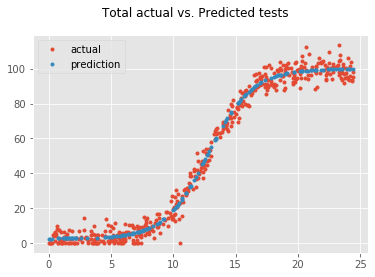

In [12]:
# Now let's see.
plt.plot(newDF[columns[0]], newDF[columns[1]], '.', label='actual')
plt.plot(x_test, model.predict(x_test), '.', label='prediction')
plt.suptitle("Total actual vs. Predicted tests")
plt.legend()
plt.show()

In [13]:
predictions = model.predict(x_test)

print("Mean squared error:")
print(metrics.mean_squared_error(y_test, predictions))

Mean squared error:
18.417072020593963


On this occasion, the loss on the training set is much less, and the testing set has similar levels of loss. If we look at the graph, the underestimating of power when speed is greater than 16 has mostly disappeared. We thus appear to have a better model, but only if we assume that the zero-power points we removed were illegitimate measurements, and that is not necessarily a legitimate assumption.

In [14]:
model.predict([[5]])[0][0]

3.5677762

In [15]:
model.predict([[20]])[0][0]

98.49319

In [16]:
model.predict([[100]])[0][0]

100.030205

In [17]:
model.predict([[-33]])[0][0]

2.4472275

While our model accurately predicts power where speed is between zero and 24.4, for negative speed values it still provides a positive power value, which is not desired, and for high speed values it predicts power values of around 100, where the data indicates that any datapoints with speed values higher than 24.4 have power values of 0. We will thus create a function to account for the discontinuous relationship between speed and power.

In [18]:
def predictPower(speed):
        try:
            speed = float(speed)
            if speed < 0:
                return "Speed cannot have a negative value."
            elif speed > 24.399:
                return "0"
            else:
                speed = np.array([speed])
                result = model.predict(speed)
                print(result[0][0])
                return str(result[0][0])
        except:
            return "Speed must be a number."

In [19]:
predictPower(5)

3.5677762


'3.5677762'

In [20]:
predictPower(20)

98.49319


'98.49319'

In [21]:
predictPower(100)

'0'

In [22]:
predictPower(-33)

'Speed cannot have a negative value.'

For a comparison between this machine learning model and quadratic and linear regression models, see [here](https://github.com/ashleycampion/GMIT_fundamentals_of_data_analysis_module/blob/main/Project.ipynb).